# Deep Learning Grid Search

We are going to tune the following parameters:

* batch size and training epochs.
* learning rate
* network weight initialization.
* activation functions.
* dropout regularization.
* number of neurons in the hidden layer.

In [ ]:
import sys
import pandas
import numpy
import sklearn
import keras


In [2]:
import pandas as pd
import numpy as np

names = ['n_pregnant', 'glucose_concentration', 'blood_pressuer (mm Hg)', 'skin_thickness (mm)', 'serum_insulin (mu U/ml)',
        'BMI', 'pedigree_function', 'age', 'class']
  
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['diabetes.csv']))
df.head()

Saving diabetes.csv to diabetes (1).csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Describe the dataset
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df[df['Glucose'] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [5]:
# Preprocess the data, mark zero values as NaN and drop
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns:
    df[col].replace(0, np.NaN, inplace=True)
    
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Drop rows with missing values
df.dropna(inplace=True)

# summarize the number of rows and columns in df
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# Convert dataframe to numpy array
dataset = df.values
print(dataset.shape)

(392, 9)


In [8]:
# split into input (X) and an output (Y)
# x has all variables, y has all outputs 
X = dataset[:,0:8]
Y = dataset[:, 8].astype(int)

In [9]:
print(X.shape)
print(Y.shape)
print(Y[:5])

(392, 8)
(392,)
[0 1 1 1 1]


In [11]:
# Normalize the data using sklearn StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)

# Transform and display the training data
X_standardized = scaler.transform(X)

data = pd.DataFrame(X_standardized)
data.describe()

,0,1,2,3,4,5,6,7
count,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02
mean,-4.021726e-17,3.129583e-17,-4.641624e-16,1.042250e-16,6.485742e-17,1.543550e-16,3.880116e-17,1.028089e-16
std,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00
min,-1.029213e+00,-2.161731e+00,-3.739001e+00,-2.108484e+00,-1.196867e+00,-2.120941e+00,-1.269525e+00,-9.682991e-01
25%,-7.174265e-01,-7.665958e-01,-6.941640e-01,-7.755315e-01,-6.681786e-01,-6.676780e-01,-7.340909e-01,-7.719850e-01
50%,-4.056403e-01,-1.176959e-01,-5.314565e-02,-1.384444e-02,-2.574448e-01,1.621036e-02,-2.131475e-01,-3.793569e-01
75%,5.297185e-01,6.609841e-01,5.878727e-01,7.478426e-01,2.859877e-01,5.718696e-01,4.751644e-01,5.040564e-01
max,4.271153e+00,2.445459e+00,3.151946e+00,3.223325e+00,5.812990e+00,4.846172e+00,5.497667e+00,4.921123e+00


In [12]:
# import necessary sklearn and keras packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

# Do a grid search for the optimal batch size and number of epochs
# import necessary packages
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [13]:

# Define a random seed
seed = 6
np.random.seed(seed)
# Start defining the model
'''
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, input_dim = 16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model
'''
def create_model():
    #create the model
    model=Sequential()
    #this is the input layer
    model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
    #first 8 is the number of nodes,relu=rectified linear unit
    
    #now hidden layer which comes in between input and output layers
    model.add(Dense(4, input_dim=8, kernel_initializer='normal', activation='relu'))
    
    #output layer
    model.add(Dense(1, activation='sigmoid'))#because we are doing a binary classification problem
    
    #compile the model
    adam=Adam(lr= 0.01)#lr is the learning rate
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model
    
# create the model
model = KerasClassifier(build_fn = create_model, verbose = 0)

# define the grid search parameters
batch_size = [16, 32, 64, 128]
epochs = [10, 50 ,100]

# make a dictionary of the grid search parameters
param_grid = dict(batch_size=batch_size, epochs=epochs)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_standardized, Y)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] batch_size=16, epochs=10 ........................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ batch_size=16, epochs=10, score=0.747, total=   0.8s
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ............ batch_size=16, epochs=10, score=0.608, total=   0.8s
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] ............ batch_size=16, epochs=10, score=0.821, total=   0.7s
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


[CV] ............ batch_size=16, epochs=10, score=0.846, total=   0.7s
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s


[CV] ............ batch_size=16, epochs=10, score=0.833, total=   0.7s
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s


[CV] ............ batch_size=16, epochs=50, score=0.747, total=   1.6s
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.4s remaining:    0.0s


[CV] ............ batch_size=16, epochs=50, score=0.658, total=   1.5s
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.9s remaining:    0.0s


[CV] ............ batch_size=16, epochs=50, score=0.705, total=   1.4s
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.3s remaining:    0.0s


[CV] ............ batch_size=16, epochs=50, score=0.808, total=   1.6s
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.9s remaining:    0.0s


[CV] ............ batch_size=16, epochs=50, score=0.795, total=   1.5s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........... batch_size=16, epochs=100, score=0.734, total=   2.4s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........... batch_size=16, epochs=100, score=0.696, total=   2.5s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........... batch_size=16, epochs=100, score=0.782, total=   2.5s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........... batch_size=16, epochs=100, score=0.795, total=   2.5s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........... batch_size=16, epochs=100, score=0.795, total=   2.7s
[CV] batch_size=32, epochs=10 ........................................
[CV] ............ batch_size=32, epochs=10, score=0.785, total=   0.6s
[CV] batch_size=32, epochs=10 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


Best: 0.788737416267395, using {'batch_size': 128, 'epochs': 100}
0.7708860754966735 (0.08862296353002007) with: {'batch_size': 16, 'epochs': 10}
0.7425511240959167 (0.05569572585555527) with: {'batch_size': 16, 'epochs': 50}
0.7604349255561829 (0.039126289397289536) with: {'batch_size': 16, 'epochs': 100}
0.7682245969772339 (0.08296712461375834) with: {'batch_size': 32, 'epochs': 10}
0.7811424732208252 (0.0926613097668695) with: {'batch_size': 32, 'epochs': 50}
0.7631288528442383 (0.0699811177428971) with: {'batch_size': 32, 'epochs': 100}
0.7631288409233093 (0.07941907087664095) with: {'batch_size': 64, 'epochs': 10}
0.7810775518417359 (0.08701677188663852) with: {'batch_size': 64, 'epochs': 50}
0.7860110402107239 (0.04920779716540022) with: {'batch_size': 64, 'epochs': 100}
0.7758195281028748 (0.0669110604888478) with: {'batch_size': 128, 'epochs': 10}
0.7708860754966735 (0.09757267512406968) with: {'batch_size': 128, 'epochs': 50}
0.788737416267395 (0.08563115120785049) with: {'bat

In [15]:
best_batch_size = grid_results.best_params_['batch_size'] #128 # 64 , 32
best_epochs = grid_results.best_params_['epochs'] #100 # 10  ,  50
#Best: 0.7962674498558044 with model2

In [16]:

# Do a grid search for learning rate and dropout rate
# import necessary packages
from keras.layers import Dropout

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(learn_rate, dropout_rate):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model


# create the model
model = KerasClassifier(build_fn = create_model, epochs = best_epochs, batch_size = best_batch_size, verbose = 0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2, 0.4]

# make a dictionary of the grid search parameters
param_grid = dict(learn_rate=learn_rate, dropout_rate=dropout_rate)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_standardized, Y)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.797, total=   1.0s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.620, total=   0.9s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.808, total=   0.9s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.795, total=   1.0s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.8s remaining:    0.0s


[CV] .. dropout_rate=0.0, learn_rate=0.001, score=0.821, total=   0.9s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.797, total=   1.0s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.7s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.608, total=   0.9s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.6s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.821, total=   0.9s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.6s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.833, total=   0.9s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.5s remaining:    0.0s


[CV] ... dropout_rate=0.0, learn_rate=0.01, score=0.846, total=   1.3s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.722, total=   0.9s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.709, total=   0.9s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.795, total=   0.9s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.795, total=   1.0s
[CV] dropout_rate=0.0, learn_rate=0.1 ................................
[CV] .... dropout_rate=0.0, learn_rate=0.1, score=0.795, total=   1.0s
[CV] dropout_rate=0.1, learn_rate=0.001 ..............................
[CV] .. dropout_rate=0.1, learn_rate=0.001, score=0.785, total=   1.1s
[CV] dropout_rate=0.1, learn_rate=0.001 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


Best: 0.7810126543045044, using {'dropout_rate': 0.0, 'learn_rate': 0.01}
0.7681596875190735 (0.0745017573484862) with: {'dropout_rate': 0.0, 'learn_rate': 0.001}
0.7810126543045044 (0.08818797740289828) with: {'dropout_rate': 0.0, 'learn_rate': 0.01}
0.7629990339279175 (0.039240713606295524) with: {'dropout_rate': 0.0, 'learn_rate': 0.1}
0.765692949295044 (0.08674821194935547) with: {'dropout_rate': 0.1, 'learn_rate': 0.001}
0.7733852744102478 (0.08099991854232982) with: {'dropout_rate': 0.1, 'learn_rate': 0.01}
0.7454722404479981 (0.09766193278658082) with: {'dropout_rate': 0.1, 'learn_rate': 0.1}
0.7733203530311584 (0.0903803004336653) with: {'dropout_rate': 0.2, 'learn_rate': 0.001}
0.7734177112579346 (0.09029047133915956) with: {'dropout_rate': 0.2, 'learn_rate': 0.01}
0.7631937623023987 (0.08176982084815004) with: {'dropout_rate': 0.2, 'learn_rate': 0.1}
0.7451152205467224 (0.08510088218537588) with: {'dropout_rate': 0.4, 'learn_rate': 0.001}
0.7606945753097534 (0.088002264247499

In [17]:
best_dropout_rate = grid_results.best_params_['dropout_rate'] #0.1 # 0.0
best_learn_rate = grid_results.best_params_['learn_rate'] #0.01

In [18]:

# Do a grid search to optimize kernel initialization and activation functions
# import necessary packages

# Define a random seed
seed = 6
np.random.seed(seed)
'''
# Start defining the model
def create_model(activation, init):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim = 8, kernel_initializer= init, activation= activation))
    model.add(Dense(16, input_dim = 8, kernel_initializer= init, activation= activation))
    model.add(Dense(8, input_dim = 16, kernel_initializer= init, activation= activation))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    adam = Adam(lr = best_learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

'''
def create_model(activation, init):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim = 8, kernel_initializer= init, activation= activation))
    model.add(Dense(4, input_dim = 8, kernel_initializer= init, activation= activation))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = best_learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model


# create the model
model = KerasClassifier(build_fn = create_model, epochs = best_epochs, batch_size = best_batch_size, verbose = 0)

# define the grid search parameters
activation = ['softmax', 'relu', 'tanh', 'linear']
init = ['uniform', 'normal', 'zero']

# make a dictionary of the grid search parameters
param_grid = dict(activation = activation, init = init)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), verbose = 10)
grid_results = grid.fit(X_standardized, Y)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] activation=softmax, init=uniform ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... activation=softmax, init=uniform, score=0.747, total=   1.5s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.608, total=   1.0s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.808, total=   1.0s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.808, total=   1.0s
[CV] activation=softmax, init=uniform ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s remaining:    0.0s


[CV] .... activation=softmax, init=uniform, score=0.846, total=   1.0s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.5s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.734, total=   1.0s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.5s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.608, total=   1.0s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.5s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.833, total=   1.0s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.5s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.808, total=   1.0s
[CV] activation=softmax, init=normal .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.5s remaining:    0.0s


[CV] ..... activation=softmax, init=normal, score=0.859, total=   1.0s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.646, total=   1.0s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.570, total=   1.0s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.705, total=   1.0s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.744, total=   1.0s
[CV] activation=softmax, init=zero ...................................
[CV] ....... activation=softmax, init=zero, score=0.679, total=   1.0s
[CV] activation=relu, init=uniform ...................................
[CV] ....... activation=relu, init=uniform, score=0.747, total=   1.0s
[CV] activation=relu, init=uniform ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


Best: 0.7911067843437195, using {'activation': 'linear', 'init': 'uniform'}
0.7631937623023987 (0.08404904789108054) with: {'activation': 'softmax', 'init': 'uniform'}
0.7683544158935547 (0.09054655724624809) with: {'activation': 'softmax', 'init': 'normal'}
0.6686789989471436 (0.05899773033245815) with: {'activation': 'softmax', 'init': 'zero'}
0.7581629395484925 (0.10041631744917966) with: {'activation': 'relu', 'init': 'uniform'}
0.7835118412971497 (0.06657109841663113) with: {'activation': 'relu', 'init': 'normal'}
0.6686789989471436 (0.05899773033245815) with: {'activation': 'relu', 'init': 'zero'}
0.7657254099845886 (0.08183222723896484) with: {'activation': 'tanh', 'init': 'uniform'}
0.7707887053489685 (0.07924039790298476) with: {'activation': 'tanh', 'init': 'normal'}
0.6686789989471436 (0.05899773033245815) with: {'activation': 'tanh', 'init': 'zero'}
0.7911067843437195 (0.07968826468817176) with: {'activation': 'linear', 'init': 'uniform'}
0.7835118293762207 (0.0881164717109

In [19]:
best_activation = grid_results.best_params_['activation'] #'linear' # 'relu'
best_init =  grid_results.best_params_['init'] #'uniform' # 'normal'

In [20]:

# Do a grid search to find the optimal number of neurons in each hidden layer
# import necessary packages

# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model(neuron1, neuron2): #, neuron3
    # create model
    model = Sequential()
    model.add(Dense(neuron1, input_dim = 8, kernel_initializer= best_init, activation= best_activation))
    model.add(Dense(neuron2, input_dim = neuron1, kernel_initializer= best_init, activation= best_activation))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    adam = Adam(lr = best_learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = best_epochs, batch_size = best_batch_size, verbose = 0)

# define the grid search parameters
neuron1 = [4, 8, 16, 32]
neuron2 = [4, 8, 16, 32, 64]

# make a dictionary of the grid search parameters
param_grid = dict(neuron1 = neuron1, neuron2 = neuron2) #, neuron3 = neuron3

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(random_state=seed), refit = True, verbose = 10)
grid_results = grid.fit(X_standardized, Y)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] neuron1=4, neuron2=4 ............................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ neuron1=4, neuron2=4, score=0.835, total=   1.0s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.608, total=   1.0s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.821, total=   1.0s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.846, total=   1.0s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.808, total=   0.9s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.835, total=   1.0s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.9s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.633, total=   1.0s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.9s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.821, total=   1.0s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.9s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.846, total=   1.0s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.9s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.808, total=   1.0s
[CV] neuron1=4, neuron2=16 ...........................................
[CV] ............... neuron1=4, neuron2=16, score=0.835, total=   1.0s
[CV] neuron1=4, neuron2=16 ...........................................
[CV] ............... neuron1=4, neuron2=16, score=0.633, total=   1.0s
[CV] neuron1=4, neuron2=16 ...........................................
[CV] ............... neuron1=4, neuron2=16, score=0.821, total=   1.0s
[CV] neuron1=4, neuron2=16 ...........................................
[CV] ............... neuron1=4, neuron2=16, score=0.846, total=   1.6s
[CV] neuron1=4, neuron2=16 ...........................................
[CV] ............... neuron1=4, neuron2=16, score=0.821, total=   1.0s
[CV] neuron1=4, neuron2=32 ...........................................
[CV] ............... neuron1=4, neuron2=32, score=0.835, total=   1.0s
[CV] neuron1=4, neuron2=32 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished


Best: 0.7962674260139465, using {'neuron1': 32, 'neuron2': 4}
0.783479380607605 (0.08890601661969585) with: {'neuron1': 4, 'neuron2': 4}
0.7885426759719849 (0.07890321637345102) with: {'neuron1': 4, 'neuron2': 8}
0.7911067843437195 (0.07968826468817176) with: {'neuron1': 4, 'neuron2': 16}
0.7911392331123352 (0.08659341582599898) with: {'neuron1': 4, 'neuron2': 32}
0.7809152722358703 (0.08723055718910631) with: {'neuron1': 4, 'neuron2': 64}
0.7911067724227905 (0.0792746637362651) with: {'neuron1': 8, 'neuron2': 4}
0.7911392331123352 (0.08583080767748588) with: {'neuron1': 8, 'neuron2': 8}
0.7885426759719849 (0.07890321637345102) with: {'neuron1': 8, 'neuron2': 16}
0.7911716818809509 (0.09191151102092288) with: {'neuron1': 8, 'neuron2': 32}
0.7885426759719849 (0.07806551623412974) with: {'neuron1': 8, 'neuron2': 64}
0.7835118293762207 (0.08811647171098208) with: {'neuron1': 16, 'neuron2': 4}
0.786011028289795 (0.08311359084714863) with: {'neuron1': 16, 'neuron2': 8}
0.7936708688735962 (0

In [21]:
best_neuron1 = grid_results.best_params_['neuron1'] # 32 # 16
best_neuron2 = grid_results.best_params_['neuron2'] # 4 # 16
#best_neuron3 = 8

In [22]:
from sklearn.model_selection import train_test_split
#best model
model = Sequential()
model.add(Dense(best_neuron1, input_dim = 8, kernel_initializer= best_init, activation= best_activation))
model.add(Dense(best_neuron2, input_dim = best_neuron1, kernel_initializer= best_init, activation= best_activation))
#model.add(Dense(best_neuron3, input_dim = best_neuron2, kernel_initializer= best_init, activation= best_activation))
model.add(Dense(1, activation='sigmoid'))

In [23]:
# compile the model
adam = Adam(lr = best_learn_rate)
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
ckpt_model = 'pima-weights_best_t.hdf5'
checkpoint = ModelCheckpoint(ckpt_model, 
                            monitor='val_acc', 
                            verbose=1,
                            save_best_only=True,
                            mode='max')
callbacks_list = [checkpoint]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

print(X_train.shape)
print(X_test.shape)

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    nb_epoch=best_epochs,
                    batch_size=best_batch_size,
                    callbacks=callbacks_list,
                    verbose=1)
#model.load_weights("pima-weights_best_t.hdf5")

(313, 8)
(79, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 313 samples, validate on 79 samples
Epoch 1/100
313/313 [==============================] - 0s 379us/step - loss: 1.3697 - accuracy: 0.5048 - val_loss: 0.8292 - val_accuracy: 0.6835
Epoch 2/100
313/313 [==============================] - 0s 24us/step - loss: 0.9177 - accuracy: 0.6677 - val_loss: 0.8463 - val_accuracy: 0.3165
Epoch 3/100
313/313 [==============================] - 0s 28us/step - loss: 0.9450 - accuracy: 0.3514 - val_loss: 0.6376 - val_accuracy: 0.6835
Epoch 4/100
313/313 [==============================] - 0s 28us/step - loss: 0.7667 - accuracy: 0.6645 - val_loss: 0.7244 - val_accuracy: 0.6835
Epoch 5/100
313/313 [==============================] - 0s 29us/step - loss: 0.7005 - accuracy: 0.6773 - val_loss: 0.7085 - val_accuracy: 0.4810
Epoch 6/100
313/313 [==============================] - 0s 39us/step - loss: 0.7082 - accuracy: 0.5080 - val_loss: 0.6105 - val_accuracy: 0.7215
Epoch 7/100
313/313 [==============================] - 0s 33us/step - loss: 0.6330 - accur

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


313/313 [==============================] - 0s 32us/step - loss: 0.5706 - accuracy: 0.7157 - val_loss: 0.5602 - val_accuracy: 0.7215
Epoch 21/100
313/313 [==============================] - 0s 30us/step - loss: 0.5687 - accuracy: 0.7252 - val_loss: 0.5603 - val_accuracy: 0.7215
Epoch 22/100
313/313 [==============================] - 0s 23us/step - loss: 0.5730 - accuracy: 0.7061 - val_loss: 0.5610 - val_accuracy: 0.7215
Epoch 23/100
313/313 [==============================] - 0s 26us/step - loss: 0.5682 - accuracy: 0.7061 - val_loss: 0.5504 - val_accuracy: 0.7215
Epoch 24/100
313/313 [==============================] - 0s 27us/step - loss: 0.5677 - accuracy: 0.7188 - val_loss: 0.5472 - val_accuracy: 0.7342
Epoch 25/100
313/313 [==============================] - 0s 25us/step - loss: 0.5682 - accuracy: 0.7093 - val_loss: 0.5440 - val_accuracy: 0.7342
Epoch 26/100
313/313 [==============================] - 0s 25us/step - loss: 0.5691 - accuracy: 0.7061 - val_loss: 0.5453 - val_accuracy: 0.721

In [24]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.3f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 75.949%


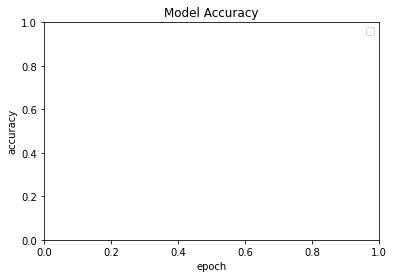

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


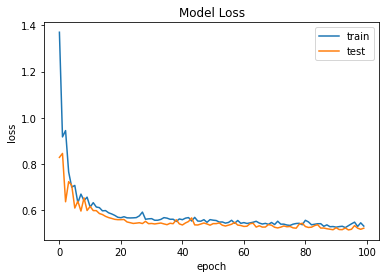

In [29]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

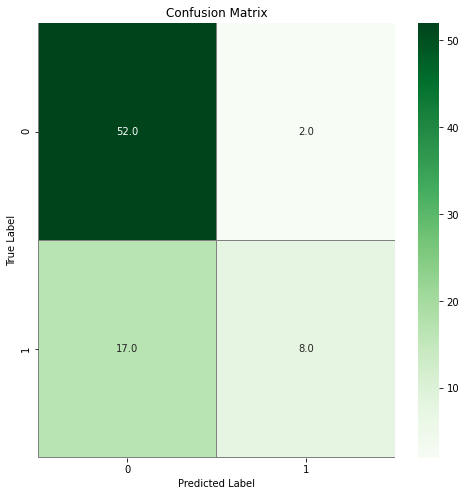

In [30]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset
y_pred = model.predict(X_test)
y_final = (y_pred > 0.5).astype(int).reshape(X_test.shape[0])
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [31]:
#from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_test, y_final))
# Generate a classification report
report = classification_report(y_test, y_final, target_names=['0','1'])

print(report)

0.759493670886076
              precision    recall  f1-score   support

           0       0.75      0.96      0.85        54
           1       0.80      0.32      0.46        25

    accuracy                           0.76        79
   macro avg       0.78      0.64      0.65        79
weighted avg       0.77      0.76      0.72        79

